Blob Detection - Teacher's Method
How 8-neighbor extrema detection works:
For each pixel, count how many of its 8 neighbors it's greater than:
  - Count = 8: Local maximum (pixel > all 8 neighbors)
  - Count = 0: Local minimum (pixel < all 8 neighbors)
  - Count = 1-7: Neither maximum nor minimum

Example 3x3 patch:
[[1 2 1]
 [2 5 2]
 [1 2 1]]
Center pixel (5) > all 8 neighbors → Local maximum

Image shape: (300, 300)
Using Gaussian scale σ = 3 (t = σ² = 9)
Gaussian kernel size: 25 pixels
LoG response range: [-5.721, 6.597]

Results:
Dark blobs (local maxima): 672
Bright blobs (local minima): 633
Total blobs: 1305


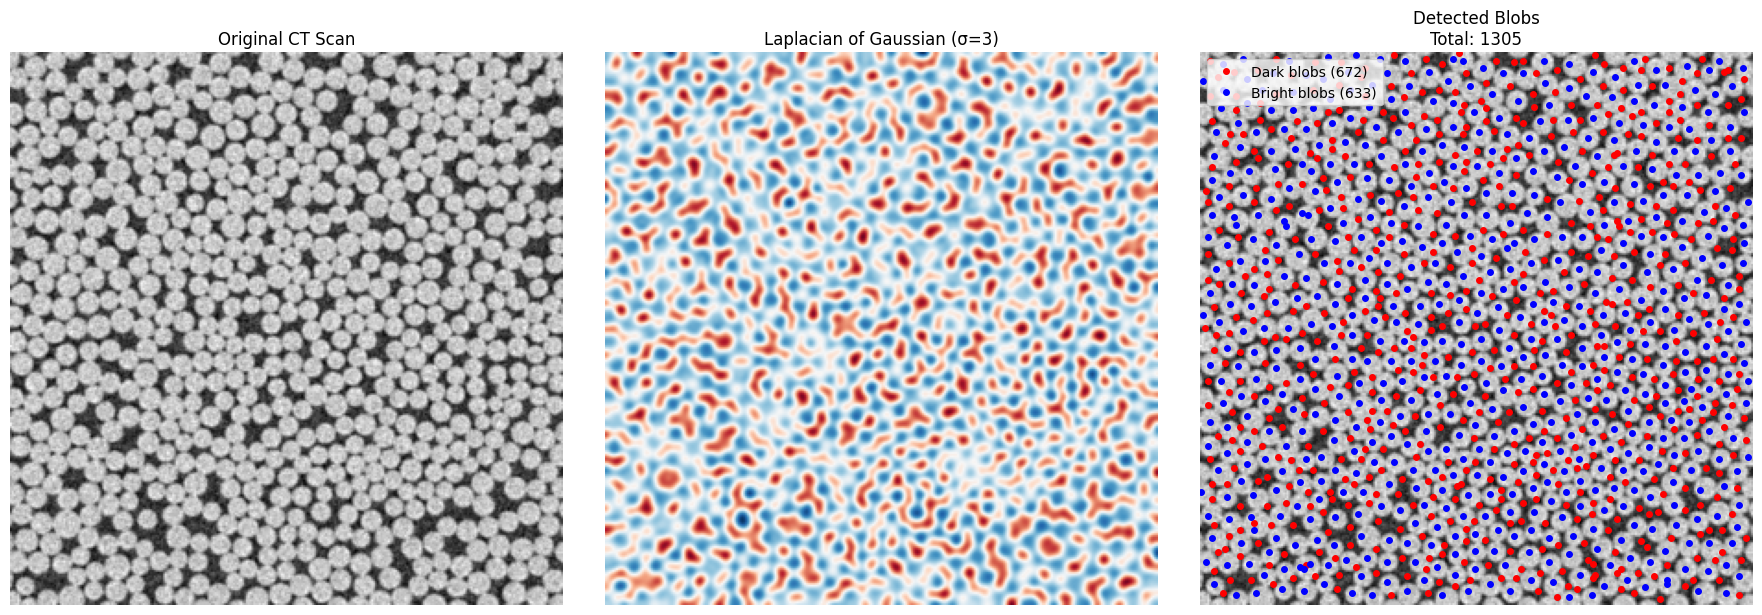


First 5 dark blob coordinates:
  1: row=0, col=140, LoG_value=-1.8393
  2: row=1, col=105, LoG_value=4.3164
  3: row=1, col=214, LoG_value=3.5633
  4: row=3, col=41, LoG_value=4.3099
  5: row=3, col=122, LoG_value=2.2316

First 5 bright blob coordinates:
  1: row=1, col=84, LoG_value=-1.8081
  2: row=2, col=69, LoG_value=-2.0639
  3: row=3, col=23, LoG_value=-2.3267
  4: row=3, col=97, LoG_value=-2.5197
  5: row=3, col=137, LoG_value=-2.1948

Note: σ = 3 corresponds to scale t = σ² = 9
This matches the requirement to detect blobs at scale t = 9


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.io

def gaussians(s):
    """
    Generate Gaussian and its derivatives for scale s.
    Returns g, dg, ddg (0th, 1st, 2nd derivatives)
    """
    x = np.arange(-np.ceil(4*s), np.ceil(4*s)+1)
    x = np.reshape(x, (-1,1))
    g = 1/(s*np.sqrt(2*np.pi))*np.exp(-x**2/(2*s**2))
    dg = -x/(s**2)*g
    ddg = -x/(s**2)*dg - 1/(s**2)*g
    return g, dg, ddg

def get_local_extrema_2D(L):
    """
    Find local extrema using 8-neighbor comparison.
    
    For each pixel, count how many of its 8 neighbors it's greater than:
    - If count = 8: local maximum (dark blob)
    - If count = 0: local minimum (bright blob)
    """
    r, c = L.shape
    ct_im = np.zeros((r, c))
    
    # Compare with all 8 neighbors
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == 0 and j == 0:  # Skip center pixel
                continue
            to_row = r - 1 + i
            to_col = c - 1 + j
            # Count how many neighbors current pixel is greater than
            ct_im[1:-1, 1:-1] += (L[1:-1, 1:-1] > L[1+i:to_row, 1+j:to_col])
    
    # Find coordinates of extrema
    coord_dark = np.where(ct_im[1:-1, 1:-1] == 8)    # Local maxima
    coord_bright = np.where(ct_im[1:-1, 1:-1] == 0)  # Local minima
    
    return coord_dark, coord_bright

def detect_blobs_teacher_method(image_path, scale_sigma=3):
    """
    Blob detection using teacher's method with Laplacian of Gaussian.
    
    Parameters:
    -----------
    image_path : str
        Path to image file
    scale_sigma : float
        Gaussian scale parameter (σ = 3 corresponds to t = σ² = 9)
    """
    
    # Read image
    im = skimage.io.imread(image_path).astype(float)
    if len(im.shape) == 3:
        im = np.mean(im, axis=2)  # Convert to grayscale if needed
    
    print(f"Image shape: {im.shape}")
    print(f"Using Gaussian scale σ = {scale_sigma} (t = σ² = {scale_sigma**2})")
    
    # Generate Gaussian kernels
    s = scale_sigma
    g, dg, ddg = gaussians(s)
    
    print(f"Gaussian kernel size: {g.shape[0]} pixels")
    
    # Compute Laplacian of Gaussian using separable filters
    # L = ∂²/∂x² + ∂²/∂y²
    Lxx = scipy.ndimage.convolve(scipy.ndimage.convolve(im, ddg), g.T)
    Lyy = scipy.ndimage.convolve(scipy.ndimage.convolve(im, ddg.T), g)
    L = Lxx + Lyy
    
    print(f"LoG response range: [{L.min():.3f}, {L.max():.3f}]")
    
    # Find local extrema
    coord_dark, coord_bright = get_local_extrema_2D(L)
    
    # Print results
    n_dark = len(coord_dark[0])
    n_bright = len(coord_bright[0])
    print(f"\nResults:")
    print(f"Dark blobs (local maxima): {n_dark}")
    print(f"Bright blobs (local minima): {n_bright}")
    print(f"Total blobs: {n_dark + n_bright}")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    axes[0].imshow(im, cmap='gray')
    axes[0].set_title('Original CT Scan')
    axes[0].axis('off')
    
    # Laplacian of Gaussian response
    axes[1].imshow(L, cmap='RdBu_r')
    axes[1].set_title(f'Laplacian of Gaussian (σ={s})')
    axes[1].axis('off')
    
    # Detected blobs
    axes[2].imshow(im, cmap='gray')
    axes[2].plot(coord_dark[1], coord_dark[0], '.r', markersize=8, label=f'Dark blobs ({n_dark})')
    axes[2].plot(coord_bright[1], coord_bright[0], '.b', markersize=8, label=f'Bright blobs ({n_bright})')
    axes[2].set_title(f'Detected Blobs\nTotal: {n_dark + n_bright}')
    axes[2].legend()
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return coord_dark, coord_bright, L, im

def demonstrate_extrema_detection():
    """
    Demonstrate how the 8-neighbor extrema detection works.
    """
    print("How 8-neighbor extrema detection works:")
    print("=" * 50)
    print("For each pixel, count how many of its 8 neighbors it's greater than:")
    print("  - Count = 8: Local maximum (pixel > all 8 neighbors)")
    print("  - Count = 0: Local minimum (pixel < all 8 neighbors)")
    print("  - Count = 1-7: Neither maximum nor minimum")
    print()
    
    # Simple example
    example = np.array([
        [1, 2, 1],
        [2, 5, 2],  # Center pixel = 5 (maximum)
        [1, 2, 1]
    ])
    
    print("Example 3x3 patch:")
    print(example)
    print("Center pixel (5) > all 8 neighbors → Local maximum")
    print()

# Main execution
if __name__ == "__main__":
    print("Blob Detection - Teacher's Method")
    print("=" * 40)
    
    # Show how the algorithm works
    demonstrate_extrema_detection()
    
    try:
        # Run blob detection
        coord_dark, coord_bright, L, im = detect_blobs_teacher_method('data/fiber.png', scale_sigma=3)
        
        # Additional analysis
        print(f"\nFirst 5 dark blob coordinates:")
        for i in range(min(5, len(coord_dark[0]))):
            r, c = coord_dark[0][i], coord_dark[1][i]
            print(f"  {i+1}: row={r}, col={c}, LoG_value={L[r,c]:.4f}")
        
        print(f"\nFirst 5 bright blob coordinates:")
        for i in range(min(5, len(coord_bright[0]))):
            r, c = coord_bright[0][i], coord_bright[1][i]
            print(f"  {i+1}: row={r}, col={c}, LoG_value={L[r,c]:.4f}")
            
    except FileNotFoundError:
        print("Error: 'fiber.png' not found!")
        print("Please make sure the image file is in the current directory.")
    except Exception as e:
        print(f"Error: {e}")

# Note about scale relationship:
print(f"\nNote: σ = 3 corresponds to scale t = σ² = 9")
print("This matches the requirement to detect blobs at scale t = 9")

Note: you may need to restart the kernel to use updated packages.


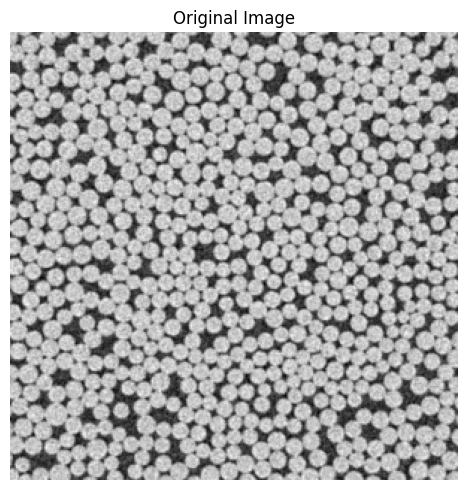

In [11]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
%pip install scipy
import numpy as np 
import matplotlib.pyplot as plt
import skimage
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter1d, gaussian_filter, gaussian_gradient_magnitude
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.io import imread

im = io.imread('data/fiber.png', as_gray=True).astype(np.float64)



# visualize the image 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(im, cmap='gray')
ax.set_title('Original Image')
ax.axis('off')
plt.tight_layout()
plt.show()

In [18]:
import numpy as np
import scipy.ndimage
import skimage.io

# Read image
im = skimage.io.imread('data/fiber.png').astype(float)

# Gaussian kernels (σ=3 for t=9)
s = 3
x = np.arange(-np.ceil(4*s), np.ceil(4*s)+1).reshape(-1,1)
g = np.exp(-x**2/(2*s**2)) / (s*np.sqrt(2*np.pi))
ddg = (x**2/s**4 - 1/s**2) * g

# Laplacian of Gaussian
Lxx = scipy.ndimage.convolve(scipy.ndimage.convolve(im, ddg), g.T)
Lyy = scipy.ndimage.convolve(scipy.ndimage.convolve(im, ddg.T), g)
L = Lxx + Lyy

# Find extrema
r, c = L.shape
ct = np.zeros((r,c))
for i in range(-1,2):
    for j in range(-1,2):
        if i or j: ct[1:-1,1:-1] += L[1:-1,1:-1] > L[1+i:r-1+i,1+j:c-1+j]

dark = np.where(ct[1:-1,1:-1]==8)
bright = np.where(ct[1:-1,1:-1]==0)

print(f"Dark blobs: {len(dark[0])}")
print(f"Bright blobs: {len(bright[0])}")
print(f"Total: {len(dark[0]) + len(bright[0])}")

Dark blobs: 672
Bright blobs: 633
Total: 1305
